In [14]:
import os
import pandas as pd
import numpy as np
from src.utils import load_json, load_known_rxns, save_json
from collections import defaultdict


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



/home/spn1560/.conda/envs/hiec/lib/python3.11/site-packages/IPython/core/completerlib.py:150: UserWarning: This is now an optional IPython functionality, setting rootmodules_cache requires you to install the `pickleshare` library.
  ip.db['rootmodules_cache'] = rootmodules_cache


In [2]:
# Load reactions and rules

imt_ops = pd.read_csv("./data/sprhea/JN3604IMT_rules.tsv", sep='\t')
min_ops = pd.read_csv("./data/sprhea/minimal1224_all_uniprot.tsv", sep='\t')

# Make toc for ops-labeled data

In [3]:
sp_ops_raw = load_json("./data/sprhea/known_rxns_swissprot_enzymes_240310.json")
save_to = "../data/sprhea/sp_ops.csv"
op_level = 'imt_rules' # 'min_rules'

id2seq = defaultdict(set)
for _, elt in sp_ops_raw.items():
    if elt[op_level] and elt['enzymes']:
        for e in elt['enzymes']:
                id2seq[e[0]].add(e[1])

# Make sure only one seq per id
for k,v in id2seq.items():
     if len(v) > 1:
          print(k,v)

id2rule = defaultdict(set)
for _, elt in sp_ops_raw.items():
    if elt['imt_rules'] and elt['enzymes']:
        for e in elt['enzymes']:
            for r in elt[op_level]:
                 id2rule[e[0]].add(r)

print(set(id2rule.keys()) ^ set(id2seq.keys())) # Make sure these are the same

data = {'Entry':[], 'Label':[], 'Sequence':[]}
for id in id2seq.keys():
     data['Entry'].append(id)
     data['Label'].append(";".join(id2rule[id]))
     data['Sequence'].append(list(id2seq[id])[0])

# Save to sp_ops subdir
df = pd.DataFrame(data=data)
df.to_csv(save_to, index=False, sep='\t')
df.head()

set()


,Entry,Label,Sequence
0,A1Z1Q3,rule0310_1;rule0007_197;rule0007_198;rule0006_...,MYPSNKKKKVWREEKERLLKMTLEERRKEYLRDYIPLNSILSWKEE...
1,A0A009IHW8,rule0310_1;rule0311_1,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...
2,A0A024B7W1,rule0010_65;rule0011_51;rule0120_1;rule0121_1,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...
3,A0A059TC02,rule0142_1;rule0143_2,MRSVSGQVVCVTGAGGFIASWLVKILLEKGYTVRGTVRNPDDPKNG...
4,A0A061AE05,rule0015_34;rule0014_29,MLTPRDENNEGDAMPMLKKPRYSSLSGQSTNITYQEHTISREERAA...


In [37]:
from src.utils import construct_sparse_adj_mat

y, idx_sample, idx_feature = construct_sparse_adj_mat("sprhea", "sp_ops")

Constructing sp_ops sparse adjacency matrix


In [6]:
y.shape

(3660, 2271)

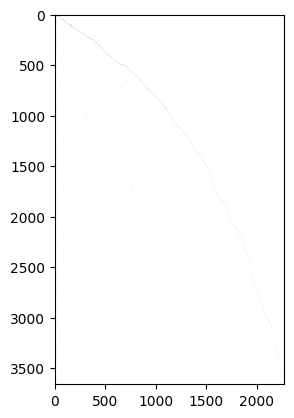

In [41]:
import matplotlib.pyplot as plt

plt.imshow(y.toarray(), cmap='binary')

In [49]:
y.count_nonzero() / (y.shape[0] * y.shape[1])

0.0010321396173660288

# Fold reaction directions into single entries and save known reactions

In [4]:
krs[0]

{'smarts': 'NC(CCC=O)C(=O)O.NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1.O=P(O)(O)O>>NC(CCC(=O)OP(=O)(O)O)C(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1',
 'min_rule': 'rule0267',
 'imt_rules': None,
 'smi2name': {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1': 'NADP(+)',
  'NC(CCC=O)C(=O)O': 'L-glutamate 5-semialdehyde',
  'O=P(O)(O)O': 'phosphate',
  'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1': 'NADPH',
  'NC(CCC(=O)OP(=O)(O)O)C(=O)O': 'L-glutamyl 5-phosphate'},
 'enzymes': [{'uniprot_id': 'A2RJM8',
   'sequence': 'MIEELGLKVKTASKEAAKLSTAEKNTFLQKLADSLVENTDRIISENAKDLAKAKGHGISEIMVDRLRLTAQRISDMATGLRQVAELPDPIGQVLQGFTNLDGLKIVQKRVPLGTVGMIFESRPNVTIDAFSLCFKTGNSVLLRGGSDAIYSNMVLVEIIKENLLSAKITDGVVELLSDTSHAEAEKMMQADKFLDVLIPRGSARLINRVKEKATVPVIETGVGNCTIFVDESADLDMATRIVINAKTQRPSVCNAAESLVVHAKIADEFLPKLQNEINKVHEV

In [6]:
# Fold reaction directions into single entry

'''
Assumes:
- Enzymes of rxn and its reverse are identical
- No more than one min rule (& reaction center) mapped to a reaction
- The reverse reverse smarts are the same as the smarts of a reaction
- Smarts are aligned with the mapped template and reaction center tuples

Stores folded as:
- Smarts & key from the smaller key arbitrarily chosen as smarts and key of folded
- Keeps a tuple of reaction center tuple tuples
- Only takes reactions that were mapped to minimal rules
'''
krs = load_json("./data/sprhea/sprhea_240310_v3_min_mapped.json")
krs = {int(k): krs[k] for k in krs}
dest = "./data/sprhea/v3_folded_pt.json"

# Enzyme filtering criteria
whitelist = [
    'Evidence at protein level',
    'Evidence at transcript level',
    # 'Inferred from homology',
]

direction_pairs = [tuple(sorted((k, krs[k]['reverse']))) for k in krs]
direction_pairs = set(direction_pairs)

krs_folded = {}
for fwd, rev in direction_pairs:
    if krs[fwd]['min_rule'] is None or krs[rev]['min_rule'] is None:
        continue
    
    enz = [e for e in krs[fwd]['enzymes'] if e['existence'] in whitelist]
    krs_folded[fwd] = {
        'smarts': krs[fwd]['smarts'],
        'min_rules': [krs[fwd]['min_rule'], krs[fwd]['min_rule']],
        'rcs': [krs[fwd]['reaction_center'],  krs[rev]['reaction_center']],
        'enzymes': enz,
        'rhea_ids': list(set(krs[fwd]['rhea_ids'] + krs[rev]['rhea_ids'])),
        'reverse': rev
    }

print(len(krs_folded))
save_json(krs_folded, dest)

6653


In [10]:
# Save toc to file
save_to = "./data/sprhea/v3_folded_pt.csv"

# Filter out duplicate sequences

# Seq to upid dict
unique_seqs = defaultdict(set)
for k,v in krs_folded.items():
    for e in v['enzymes']:
        unique_seqs[e['sequence']].add(e['uniprot_id'])

for k,v in unique_seqs.items():
    unique_seqs[k] = sorted(v)

# Make toc csv thing
chosen_upid_to_rhashes = defaultdict(set)
chosen_upid_to_sequence = {}
for k,v in krs_folded.items():
    for e in v['enzymes']:
        seq = e['sequence']
        chosen_upid = unique_seqs[seq][0] # Choose first of sorted upids of unique seq
        chosen_upid_to_rhashes[chosen_upid].add(str(k))
        chosen_upid_to_sequence[chosen_upid] = seq

data = {'Entry':[], 'Label':[], 'Sequence':[]}
for id in chosen_upid_to_sequence.keys():
     data['Entry'].append(id)
     data['Label'].append(";".join(chosen_upid_to_rhashes[id]))
     data['Sequence'].append(chosen_upid_to_sequence[id])

# Save to sp_ops subdir
df = pd.DataFrame(data=data)
df.to_csv(save_to, index=False, sep='\t')
print(len(df))
df.head()


26127


,Entry,Label,Sequence
0,P0A6W3,1123,MLVWLAEHLVKYYSGFNVFSYLTFRAIVSLLTALFISLWMGPRMIA...
1,P9WMW7,1123,MRQILIAVAVAVTVSILLTPVLIRLFTKQGFGHQIREDGPPSHHTK...
2,O66465,1123,MLYQLALLLKDYWFAFNVLKYITFRSFTAVLIAFFLTLVLSPSFIN...
3,Q8MJ30,3097;7946,MAAAAAGEARRVLVYGGRGALGSRCVQAFRARNWWVASIDVVENEE...
4,P38489,3097;7946,MDIISVALKRHSTKAFDASKKLTPEQAEQIKTLLQYSPSSTNSQPW...


# Consolidate swissprot esm embeddings

In [8]:
import os
from tqdm import tqdm
import subprocess
import csv
from src.utils import load_embed

In [13]:
in_dir = "/projects/p30041/spn1560/hiec/data/sprhea/esm_240524"
out_dir = "/projects/p30041/spn1560/hiec/data/sprhea/esm"

mismatches = []
for fn in tqdm(os.listdir(in_dir)):
    if fn in os.listdir(out_dir):
        in_id, in_embed = load_embed(f"{in_dir}/{fn}", embed_key=33)
        out_id, out_embed = load_embed(f"{out_dir}/{fn}", embed_key=33)
        
        if all(in_embed == out_embed):
            continue
        elif all((in_embed - out_embed) < 1e-5):
            subprocess.run(['cp', f"{in_dir}/{fn}", f"{out_dir}/"])
        else:
            mismatches.append((in_id, out_id))
    else:
        subprocess.run(['cp', f"{in_dir}/{fn}", f"{out_dir}/"])
            
            


100%|██████████| 3660/3660 [01:11<00:00, 50.83it/s]


In [14]:
for fn in tqdm(os.listdir(in_dir)):
    if fn not in os.listdir(out_dir):
        in_id, in_embed = load_embed(f"{in_dir}/{fn}", embed_key=33)
        out_id, out_embed = load_embed(f"{out_dir}/{fn}", embed_key=33)
        print(in_id)

100%|██████████| 3660/3660 [00:34<00:00, 104.62it/s]


In [27]:
'''
TODO: Repeat ^^ for swissprot (from CLEAN paper)
'''

False

# Get incremental esm embeddings into project dir

In [16]:
# Put remaining uniprot ids into a fasta file
fasta_name = f"./data/sprhea/v3_incremental.fasta"
toc_path = "./data/sprhea/v3_folded_pt.csv"
existing_path = "/projects/p30041/spn1560/hiec/data/sprhea/esm"

toc = pd.read_csv(toc_path, sep='\t')
all_upids = set(toc['Entry'].tolist())
toc.set_index('Entry', inplace=True)
toc.head()

existing = set([elt[:-3] for elt in os.listdir(existing_path)])
incremental = all_upids - existing
print(len(incremental))

with open(fasta_name, 'w') as f:
    for up in incremental:
        f.write('>' + up + '\n')
        f.write(toc.loc[up, 'Sequence'] + '\n')


299


In [10]:
# Put remaining uniprot ids into a fasta file

def csv_to_fasta(csv_name, existing_data, fasta_name):
    

dataset = 'sprhea'
toc = 'sp_folded_pth'
existing_data = "/projects/p30041/spn1560/hiec/data/sprhea/esm"
csv_path = f"./data/{dataset}/{toc}.csv"
fasta_name = f"./data/{dataset}/{toc}.fasta"
csv_to_fasta(csv_path, existing_data, fasta_name)

117171it [19:20, 100.95it/s]


# Look at how many enyzmes per reaction, reactions per enzymes in sprhea folded

In [6]:
import scipy as sp
import numpy as np
import pandas as pd
from collections import Counter
def construct_sparse_adj_mat(ds_name, toc):
        '''
        Returns sparse representation of sample x feature adjacency matrix
        and lookup of sample names from row idx key.

        Args
            - ds_name: Str name of dataset
            - toc: Table of contents csv

        Returns
            -
        '''      
        # Load from dataset "table of contents csv"
        df = pd.read_csv(f"./data/{ds_name}/{toc}.csv", delimiter='\t')
        df.set_index('Entry', inplace=True)
        sample_idx = {}
        feature_idx = {}
        
        # Construct ground truth protein-function matrix
        print(f"Constructing {ds_name}:{toc} sparse adjacency matrix")
        row, col, data = [], [], [] # For csr
        for i, elt in enumerate(df.index):
            labels = df.loc[elt, 'Label'].split(';')
            sample_idx[elt] = i
            for label in labels:
                if label in feature_idx:
                    j = feature_idx[label]
                else:
                    j = len(feature_idx)
                    feature_idx[label] = j
                row.append(i)
                col.append(j)
                data.append(1)
                
            print(f"{i}", end='\r')

        adj = sp.sparse.csr_matrix((data, (row, col)), shape=(len(sample_idx), len(feature_idx)))
        idx_sample = {v:k for k,v in sample_idx.items()}
        idx_feature = {v:k for k,v in feature_idx.items()}
            
        return adj, idx_sample, idx_feature

Constructing sprhea:sp_folded_pth sparse adjacency matrix
117170 enzymes
7092 reactions
22.375634517766496 proteins per reaction
1.3543398480839806 reactions per protein
Constructing sprhea:sp_folded_pt sparse adjacency matrix
27833

27834 enzymes
7056 reactions
7.758219954648526 proteins per reaction
1.9667313357763887 reactions per protein


In [ ]:
dataset = 'sprhea'
toc = 'sp_folded_pth'
adj, idx_sample, idx_feature = construct_sparse_adj_mat(dataset, toc)
print(adj.shape[0], 'enzymes')
print(adj.shape[1], 'reactions')
print(adj.sum(axis=0).mean(), "proteins per reaction")
print(adj.sum(axis=1).mean(), "reactions per protein")

labels_per_prot = np.array(adj.sum(axis=1)).reshape(-1,)
ct = Counter(labels_per_prot)
x, h = list(ct.keys()), list(ct.values())
plt.bar(x, h)
plt.yscale('log')
plt.xticks(np.arange(1, max(x) + 1))
plt.ylabel("# enzymes")
plt.xlabel("# reactions")
plt.xticks(rotation=90)
plt.show()

prots_per_label = np.array(adj.sum(axis=0)).reshape(-1,)
ct = Counter(prots_per_label)
x, h = list(ct.keys()), list(ct.values())
plt.figure(figsize=(9,6))
plt.bar(x, h)
plt.yscale('log')
plt.xticks(np.arange(1, max(x) + 1))
plt.ylabel("# reactions")
plt.xlabel("# enzymes")
plt.xticks(rotation=90)
plt.xscale('log')
plt.show()

In [ ]:
dataset = 'sprhea'
toc = 'sp_folded_pt'
adj, idx_sample, idx_feature = construct_sparse_adj_mat(dataset, toc)
print(adj.shape[0], 'enzymes')
print(adj.shape[1], 'reactions')
print(adj.sum(axis=0).mean(), "proteins per reaction")
print(adj.sum(axis=1).mean(), "reactions per protein")

labels_per_prot = np.array(adj.sum(axis=1)).reshape(-1,)
ct = Counter(labels_per_prot)
x, h = list(ct.keys()), list(ct.values())
plt.bar(x, h)
plt.yscale('log')
plt.xticks(np.arange(1, max(x) + 1))
plt.ylabel("# enzymes")
plt.xlabel("# reactions")
plt.xticks(rotation=90)
plt.show()

prots_per_label = np.array(adj.sum(axis=0)).reshape(-1,)
ct = Counter(prots_per_label)
x, h = list(ct.keys()), list(ct.values())
plt.figure(figsize=(9,6))
plt.bar(x, h)
plt.yscale('log')
plt.xticks(np.arange(1, max(x) + 1))
plt.ylabel("# reactions")
plt.xlabel("# enzymes")
plt.xticks(rotation=90)
plt.xscale('log')
plt.show()

# Make folded reactions x min ops labels tocs

In [10]:
from src.utils import load_known_rxns
import pandas as pd

In [11]:
krs = load_known_rxns("./data/sprhea/known_rxns_240310_v2_folded_protein_transcript.json")
save_to = "./data/sprhea/sp_folded_pt_rxns_x_min_ops.csv"

In [12]:
# Make sure all entreis have exactly two min ops
for k,v in krs.items():
    if len(v['min_rules']) != 2:
        print(v)
        break

In [15]:
# Make toc
data = {'Entry':[], 'Label':[]}
for k,v in krs.items():
     min_ops = sorted(v['min_rules']) # Canonical order
     data['Entry'].append(k)
     data['Label'].append("_".join(min_ops))

# Save to sp_ops subdir
df = pd.DataFrame(data=data)
df.to_csv(save_to, index=False, sep='\t')
df.head()

,Entry,Label
0,R84126efbb9122177f50f81fcff58422c31a5cf7ef7254...,rule0310_rule0311
1,R922e16ad056d0d9e87f61239c734efcf9fafb99c77cc3...,rule0120_rule0121
2,R8d9c400039c4568d063fa0a51b012da463f56d8a598cf...,rule0010_rule0011
3,R5386d7c400c7c774dc0d52a933c7b4f676c4effc8a72b...,rule0142_rule0143
4,R57b2bc5bcccd3d7e9a71b4c948ad01d180e83e03cd89e...,rule0142_rule0143


In [18]:
len(set(df.loc[:, 'Label'])), len(df)

(434, 7094)